In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy
import scipy
import math
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import sys
import os
#import lmod
# lmod.load('system')
# lmod.load('texlive')
# lmod.
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
import hpc_reports
#
def running_mean(X,n=10):
    return (numpy.cumsum(numpy.insert(X,0,0))[n:] - numpy.cumsum(numpy.insert(X,0,0))[:-n])/n
#
#data_file_name = 'data/sacct_serc_20200622.out'
#data_file_name = 'data/sacct_serc_20200724.pkl'

In [172]:
# n_cpus:
n_cpus = 1
if 'SLURM_JOB_ID' in os.environ.keys():
    # running in SLURM...
    if 'SLURM_JOB_CPUS_PER_NODE' in os.environ.keys():
        n_cpus = max( int(os.environ['SLURM_JOB_CPUS_PER_NODE']), 1)
    else:
        n_cpus = 1
else:
    #n_cpus = min(8, mpp.cpu_count())
    # huh? we want at least 1, then about 3/4 of all *actual* cpus. parallelizing onto hyperthreads
    #. does not usually gain much (if anything)
    n_cpus = max(1, int((mpp.cpu_count()/2)*.8))
#
# or specify here:
#n_cpus = 4
#
print('** n_cpus: ', n_cpus)

** n_cpus:  3


In [173]:
#end_dtm = dtm.datetime.now()+dtm.timedelta(days=1)
N_report_len = 180
end_dtm = dtm.datetime(2022,8,1)
end_date = end_dtm.date()
start_date = end_date - dtm.timedelta(days=N_report_len)
print('*** dates: {} - {}'.format(start_date, end_date))
ft_min = mpd.date2num(start_date)
ft_max = mpd.date2num(end_date)
#partition='serc'
partition=None
group='oneillm'
#group='edunham'
sacct_h5_file = f'sacct_data/sacct_p{str(partition).upper()}_g{str(group).upper()}_{start_date.year:04}{start_date.month:02}{start_date.day:02}_{end_dtm.year:04}{end_dtm.month:02}{end_dtm.day:02}.h5'
print(f'*** sacct_h5_file: {sacct_h5_file}')
# NOTE: to get individual users, eg to get Eric's group usage:
#. sacct --allusers --user=labraha2 --start=2022-01-01 --end=2022-06-15
#
print(f'*** h5_exists({sacct_h5_file}): {os.path.isfile(sacct_h5_file)}')
#

*** dates: 2022-02-02 - 2022-08-01
*** sacct_h5_file: sacct_data/sacct_pNONE_gONEILLM_20220202_20220801.h5
*** h5_exists(sacct_data/sacct_pNONE_gONEILLM_20220202_20220801.h5): True


In [174]:
# NOTE: additional options can be passed in the more_options=[] arrary, or just as sacct_{option-name}={val}
#
if os.path.isfile(sacct_h5_file):
    print('*** Creating SACCT object from HDF5 {}'.format(sacct_h5_file))
    SACCT_obj = hpc_lib.SACCT_data_from_h5(sacct_h5_file, keep_raw_data=False, n_cpu=n_cpus)
    #
    
else:
    print('*** Fetching SACCT data directly')
    SACCT_obj = hpc_lib.SACCT_data_direct(group=group, partition=partition, start_date=str(start_date),
                                          n_cpu=n_cpus,
                                          end_date=str(end_date), keep_raw_data=False)
    print(f'** writing HDF5: {sacct_h5_file}')
    SACCT_obj.write_hdf5(sacct_h5_file)
    #
#
print('** ', SACCT_obj.jobs_summary.dtype.names)

*** Creating SACCT object from HDF5 sacct_data/sacct_pNONE_gONEILLM_20220202_20220801.h5
**  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent', 'NGPUs')


In [175]:
# get a partition obj too:
#print('*** Fetching SACCT data directly')
partition_onm = 'oneillm'
group_onm = None
h5_oneillm = f'sacct_data/sacct_p{str(partition_onm).upper()}_g{str(group_onm).upper()}_{start_date.year:04}{start_date.month:02}{start_date.day:02}_{end_dtm.year:04}{end_dtm.month:02}{end_dtm.day:02}.h5'

#
if os.path.isfile(h5_oneillm):
    print('*** Creating SACCT object from HDF5 {}'.format(h5_oneillm))
    SACCT_oneillm = hpc_lib.SACCT_data_from_h5(h5_oneillm, keep_raw_data=False, n_cpu=n_cpus)
    #
    
else:

    SACCT_oneillm = hpc_lib.SACCT_data_direct(group=group_onm, partition=partition_onm, 
                                              start_date=str(start_date),
                                          n_cpu=n_cpus,
                                          end_date=str(end_date), keep_raw_data=False)
    print(f'** writing HDF5: {h5_oneillm}')
    SACCT_oneillm.write_hdf5(h5_oneillm)



*** Creating SACCT object from HDF5 sacct_data/sacct_pONEILLM_gNONE_20220202_20220801.h5


In [20]:
# oneillm users:
print('** ', numpy.unique(SACCT_oneillm['User']))

**  [b'arunbk' b'haofu' b'hsstern' b'ipshi91' b'oneillm' b'regirock']


In [21]:
max_submit, max_start = [mpd.num2date(numpy.nanmax(SACCT_obj.jobs_summary[cl])) for cl in ['Start', 'Submit'] ]
print('*** max_submit: {}, max_start: {}'.format(*[mpd.num2date(numpy.nanmax(SACCT_obj.jobs_summary[cl]))
                                                   for cl in ['Start', 'Submit'] ]))
print('** cols: ', SACCT_obj.jobs_summary.dtype.names)

*** max_submit: 2022-07-31 20:45:25+00:00, max_start: 2022-07-31 19:30:52+00:00
** cols:  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent', 'NGPUs')


In [22]:
# NOTE: add this to the __init__. would be nice to refactor the code a bit to better handle inheritance.
if not 'chunk_size' in SACCT_obj.__dict__.keys():
    print('*** assigning chunk_size: ', chunk_size)
    SACCT_obj.chunk_size=1000

In [23]:
print('*** ', len(SACCT_obj.jobs_summary['Group']))
print('*** ', len(SACCT_oneillm['Group']))

***  19105
***  1877


** quantiles: {} [ 13. 192. 394. 624.]
**  270.0744
**  192.0
**  328.2280653214164


Text(0.5, 1.0, 'CDF of CPU Usage: partitoin=oneillm ')

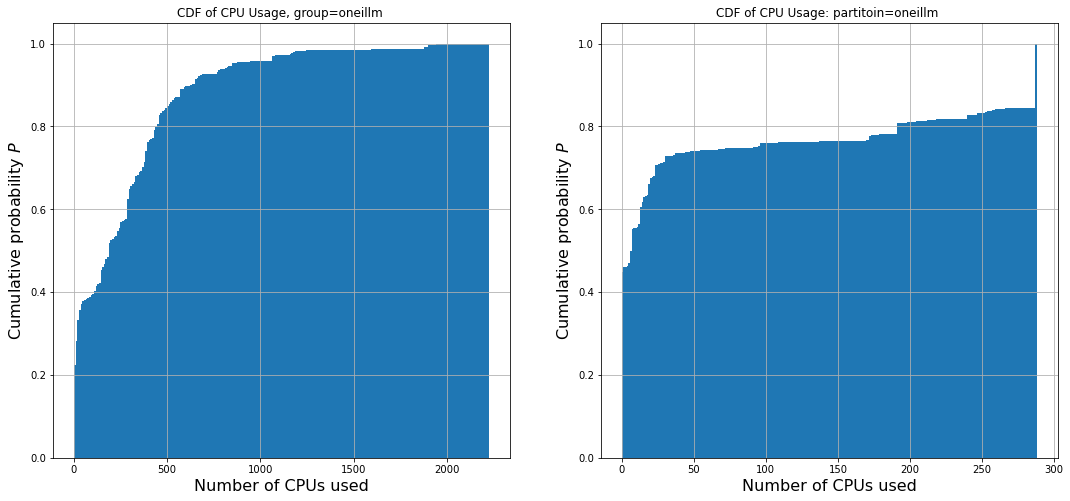

In [24]:
#N = 5456.
N=1
quantiles = numpy.quantile(SACCT_obj.cpu_usage['N_cpu'], [.25, .5, .75, .9])
quantiles_onm = numpy.quantile(SACCT_oneillm.cpu_usage['N_cpu'], [.25, .5, .75, .9])

print('** quantiles: {}', quantiles/N)
print('** ', numpy.mean(SACCT_obj.cpu_usage['N_cpu'])/N)
print('** ', numpy.median(SACCT_obj.cpu_usage['N_cpu'])/N)
print('** ', numpy.std(SACCT_obj.cpu_usage['N_cpu'])/N)
#
# get some jobs_summary stats....
fg = plt.figure(figsize=(18,8))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.grid()
hh = ax1.hist(SACCT_obj.cpu_usage['N_cpu']/N, bins=250, cumulative=True, density=True)
ax1.set_xlabel('Number of CPUs used', size=16)
ax1.set_ylabel('Cumulative probability $P$', size=16)
ax1.set_title('CDF of CPU Usage, group=oneillm ')

ax2.grid()
hh = ax2.hist(SACCT_oneillm.cpu_usage['N_cpu']/N, bins=250, cumulative=True, density=True)
ax2.set_xlabel('Number of CPUs used', size=16)
ax2.set_ylabel('Cumulative probability $P$', size=16)
ax2.set_title('CDF of CPU Usage: partitoin=oneillm ')

In [25]:
#
cpu_usage = SACCT_obj.cpu_usage
#cpu_weekly = SACCT_obj.cpu_weekly
#
#cpu_usage = SACCT_obj.active_jobs_cpu()
#
bin_size=7
cpu_weekly = SACCT_obj.active_jobs_cpu(bin_size=bin_size, t_min=None)

In [26]:
print('** ', len(cpu_usage))
print('** \n', cpu_usage[0:10])


**  5000
** 
 [(19025.        , 12., 831.) (19025.0360072 , 10., 822.)
 (19025.0720144 , 10., 822.) (19025.1080216 ,  9., 818.)
 (19025.14402881,  9., 818.) (19025.18003601,  9., 818.)
 (19025.21604321,  9., 818.) (19025.25205041,  9., 818.)
 (19025.28805761,  9., 818.) (19025.32406481,  9., 818.)]


<ipython-input-27-873d9167c620>:2: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('211')
<ipython-input-27-873d9167c620>:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('212', sharex=ax1)
<ipython-input-27-873d9167c620>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(lbls)


[Text(19000.0, 0, '2022-1-8'),
 Text(19025.0, 0, '2022-2-2'),
 Text(19050.0, 0, '2022-2-27'),
 Text(19075.0, 0, '2022-3-24'),
 Text(19100.0, 0, '2022-4-18'),
 Text(19125.0, 0, '2022-5-13'),
 Text(19150.0, 0, '2022-6-7'),
 Text(19175.0, 0, '2022-7-2'),
 Text(19200.0, 0, '2022-7-27'),
 Text(19225.0, 0, '2022-8-21')]

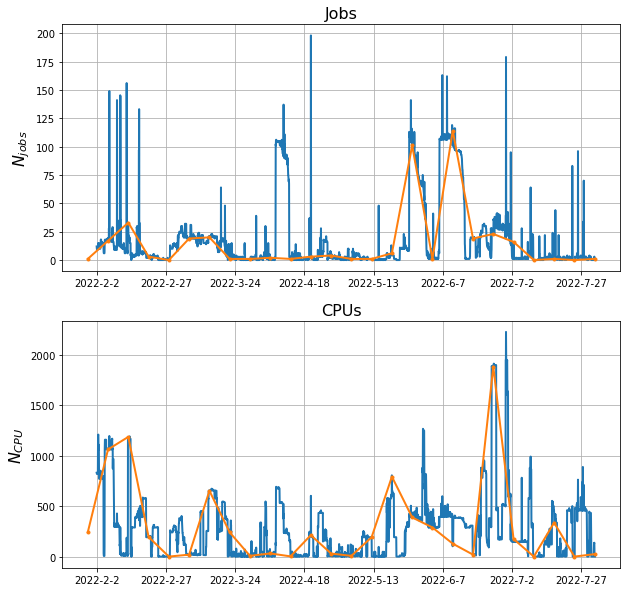

In [27]:
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_usage['time'], cpu_usage['N_jobs'], ls='-', lw=2., marker='')
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='.')
#
ax2.plot(cpu_usage['time'], cpu_usage['N_cpu'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='.')
#

ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
# fix_to_ascii(s)
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(s.get_text()))) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax2.set_xticklabels(lbls)



<ipython-input-28-70aae9fac9e3>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('121')
<ipython-input-28-70aae9fac9e3>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('122')


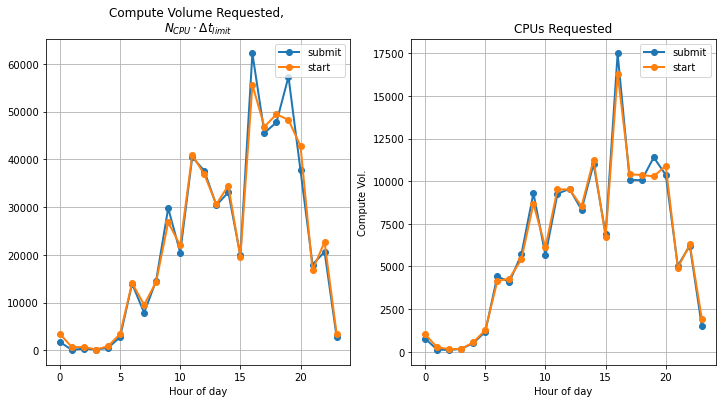

In [28]:
qs = [.5, .75, .95]
#
comp_vol_submit = SACCT_obj.get_submit_compute_vol_timeofday(qs=qs)
comp_vol_start = SACCT_obj.get_submit_compute_vol_timeofday(time_col='Start', qs=qs)
#
fg = plt.figure(figsize=(12,6))
ax1 = fg.add_subplot('121')
ax2 = fg.add_subplot('122')
ax1.grid()
ax2.grid()
#

# N = numpy.sum(comp_vol_submit['cpu-time'])
N = 1.
ax1.plot(comp_vol_submit['time'], comp_vol_submit['cpu-time']/N,
         ls='-', marker='o', lw=2., label='submit')
#print('*** ', numpy.sum(comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time'])))
#
# N = numpy.sum(comp_vol_start['cpu-time'])
N = 1 
ax1.plot(comp_vol_start['time'], comp_vol_start['cpu-time']/N,
         ls='-', marker='o', lw=2., label='start')
#print('*** ', numpy.sum(comp_vol_start['cpu-time']/N))
#
#N=numpy.sum(comp_vol_submit['cpus'])
N=1.
ax2.plot(comp_vol_submit['time'], comp_vol_submit['cpus']/N, ls='-', marker='o', lw=2., label='submit')

#N=numpy.sum(comp_vol_start['cpus'])
N=1
ax2.plot(comp_vol_start['time'], comp_vol_start['cpus']/N, ls='-', marker='o', lw=2., label='start')
#
#for k,cl in enumerate(comp_vol_tod.dtype.names[2:]):
#    ax1.plot(comp_vol_tod['time'], comp_vol_tod[cl], ls='-', marker='o', lw=2., label='$q={}$'.format(qs[k]))
#    break
#
ax1.legend(loc=0, numpoints=1)
ax1.set_title('Compute Volume Requested, \n$N_{CPU} \cdot \Delta t_{limit}$')
ax1.set_xlabel('Hour of day')
ax2.set_ylabel('Compute Vol.')

ax2.set_title('CPUs Requested')
ax2.set_xlabel('Hour of day')
ax2.legend(loc=1, numpoints=1)

Text(0.5, 0.98, 'Instantaneous Usage')

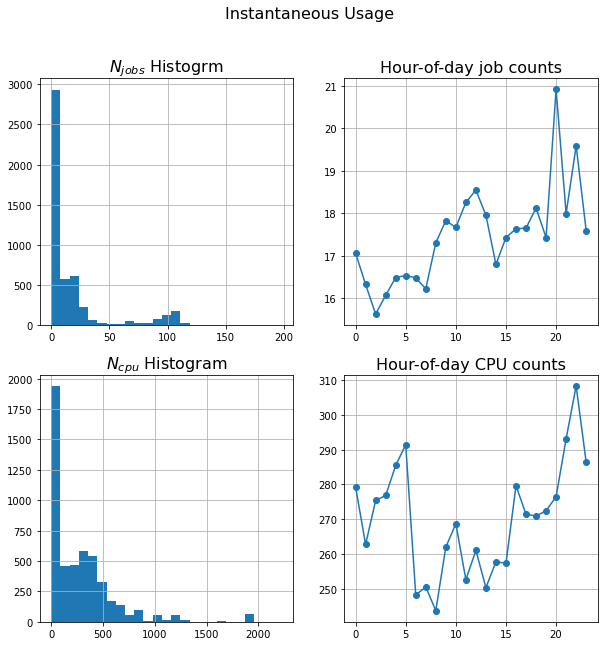

In [29]:
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
axs = [ax1, ax2, ax3, ax4]
[ax.grid() for ax in axs]
#
cpu_hourly = hpc_lib.time_bin_aggregates(XY=numpy.array([cpu_usage['time'], cpu_usage['N_cpu']]).T)
jobs_hourly = hpc_lib.time_bin_aggregates(XY=numpy.array([cpu_usage['time'], cpu_usage['N_jobs']]).T)

hh1 = ax1.hist(sorted(cpu_usage['N_jobs'])[0:int(1.0*len(cpu_usage))], bins=25, cumulative=False)
ax2.plot(jobs_hourly['x'], jobs_hourly['mean'], ls='-', marker='o')

hh3 = ax3.hist(cpu_usage['N_cpu'], bins=25)
ax4.plot(cpu_hourly['x'], cpu_hourly['mean'], ls='-', marker='o')

#ax1.set_ylim(-5., 200)
ax1.set_title('$N_{jobs}$ Histogrm', size=16)
ax2.set_title('Hour-of-day job counts', size=16)
ax3.set_title('$N_{cpu}$ Histogram', size=16)
ax4.set_title('Hour-of-day CPU counts', size=16)
#
plt.suptitle('Instantaneous Usage', size=16)

In [30]:
#TODO: looking into best way to store class meta data for HDF5 reloads.
#
weekly_hours = SACCT_obj.get_cpu_hours(bin_size=7, n_points=5000, t_min=mpd.datestr2num('2021-12-01'),
                                       t_max=mpd.datestr2num('2022-05-24'))

daily_hours = SACCT_obj.get_cpu_hours(bin_size=1, n_points=5000, t_min=mpd.datestr2num('2021-12-01'),
                                       t_max=mpd.datestr2num('2022-05-24'))

*** DEBUG t_now: 19212.700565591946, t_max: 19204.86695601852


/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3053: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)
/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3053: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)
/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3053: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)
/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3053: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


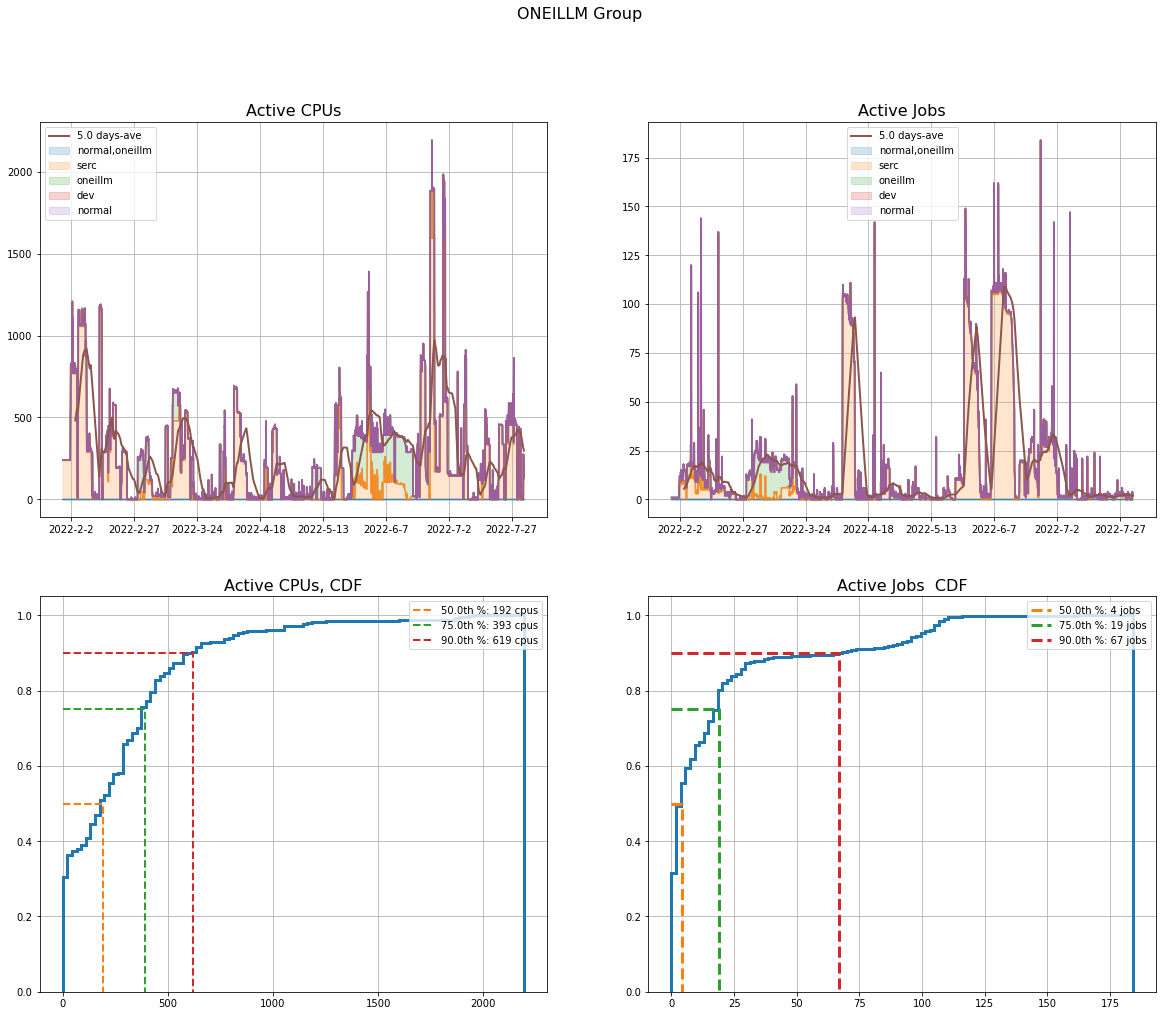

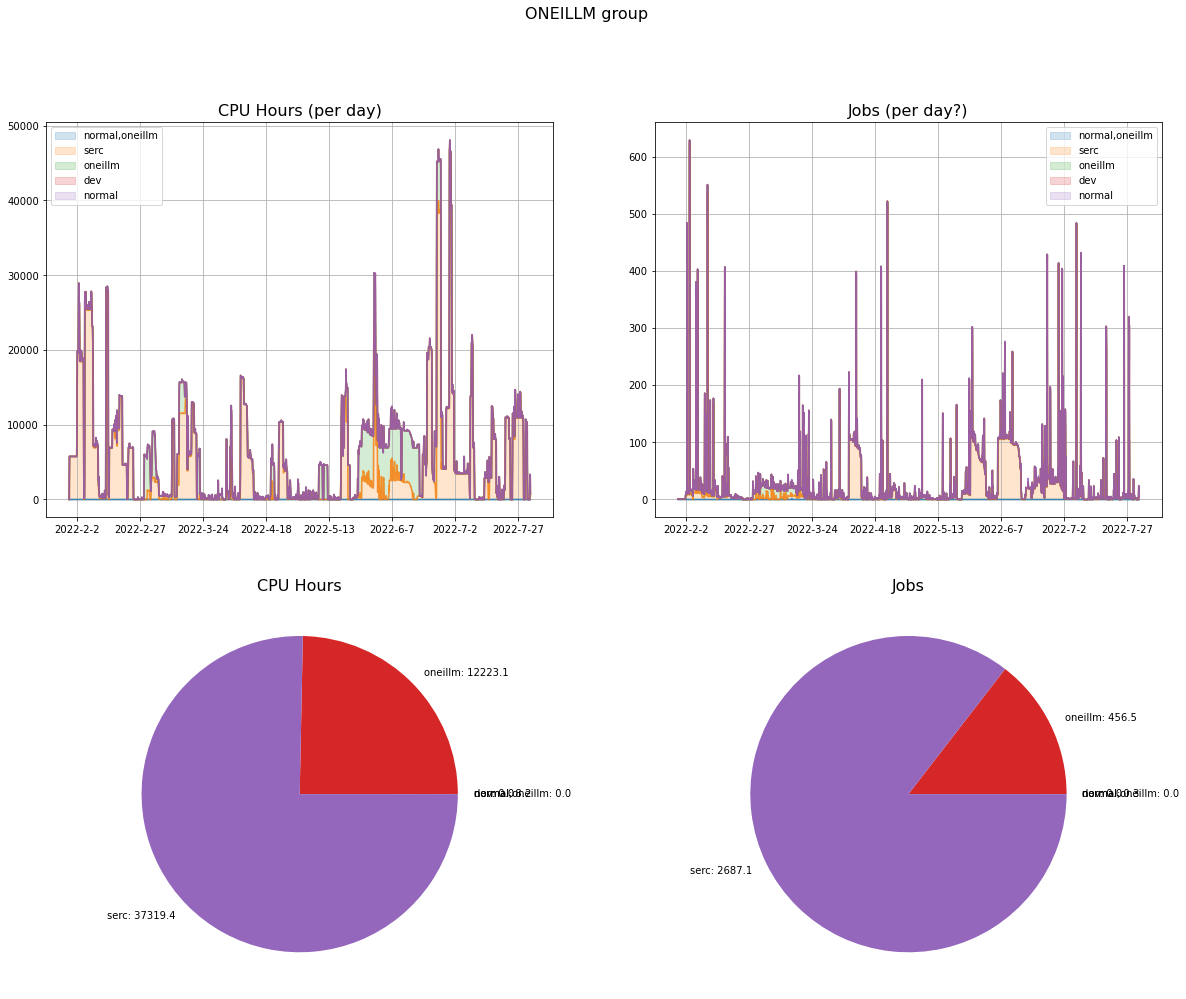

In [120]:
fg = SACCT_obj.report_activecpus_jobs_layercake_and_CDFs(group_by='Partition')
s = fg.suptitle('ONEILLM Group', size=16)
fg.axes[2].legend(loc=0)
#
fg = SACCT_obj.report_cpuhours_jobs_layercake_and_pie(group_by='Partition')
fg.suptitle('ONEILLM group', size=16)
fg2.axes[2].legend(loc=0)

*** DEBUG t_now: 19212.701854999144, t_max: 19204.85537037037


/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3053: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)
/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3053: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)
/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3053: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)
/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3053: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


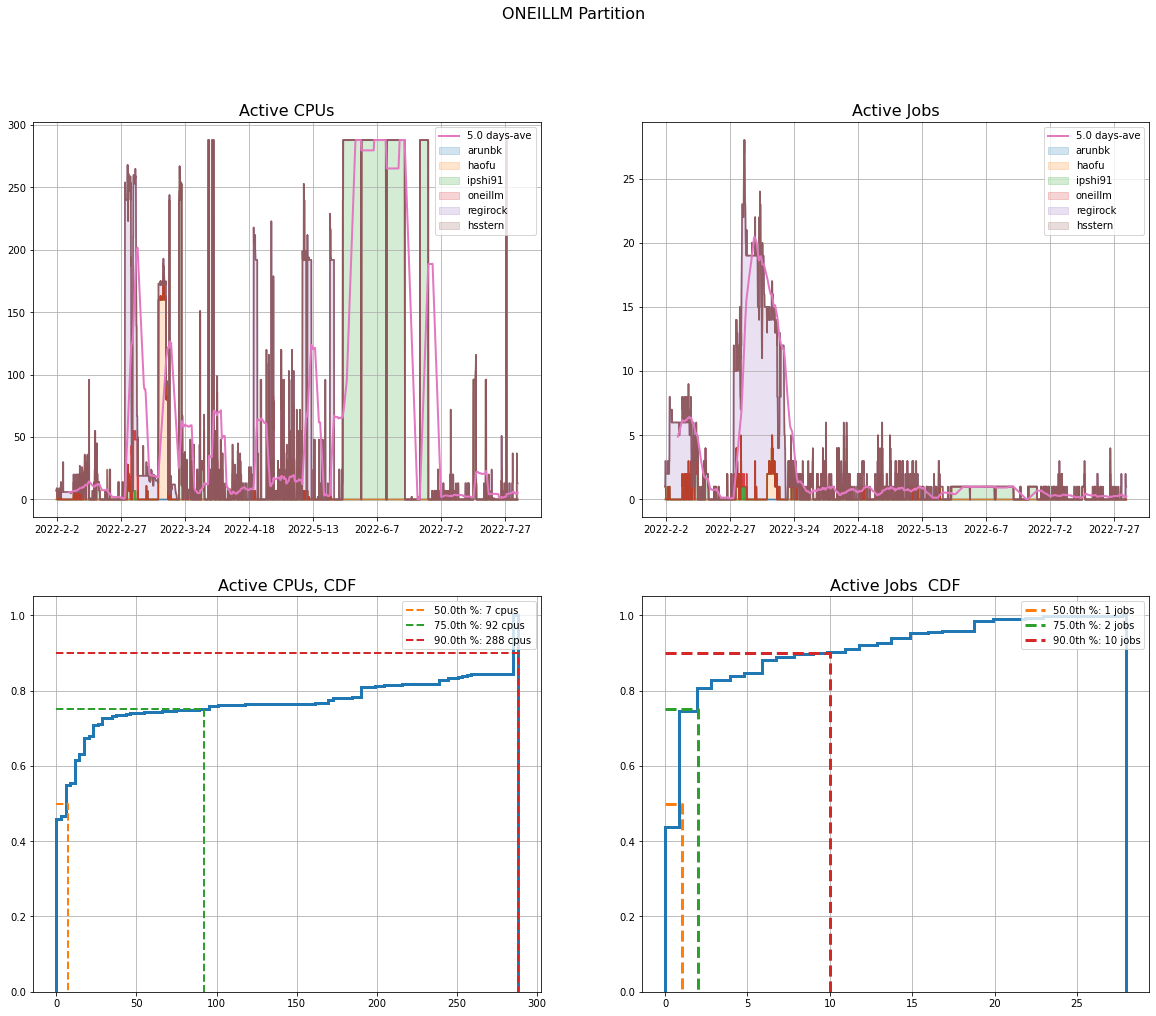

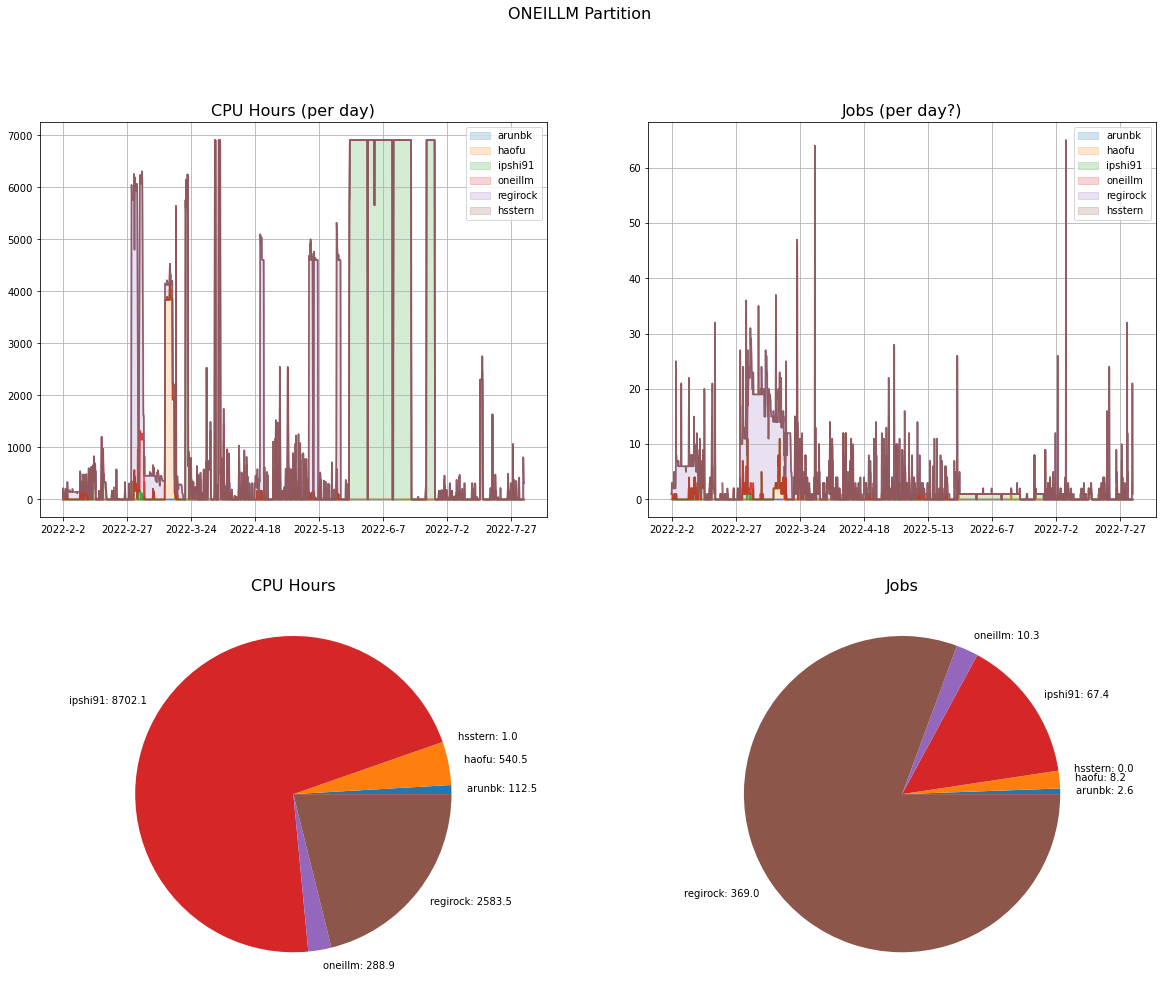

In [122]:
fg = SACCT_oneillm.report_activecpus_jobs_layercake_and_CDFs(group_by='User')
s = fg.suptitle('ONEILLM Partition', size=16)
fg.axes[2].legend(loc=0)
#
# {'autopct':'%1.1f%%'}
fg = SACCT_oneillm.report_cpuhours_jobs_layercake_and_pie(group_by='User', wedgeprops=None)
fg.suptitle('ONEILLM Partition', size=16)
fg2.axes[2].legend(loc=0)

In [40]:
unique_users = numpy.unique(SACCT_obj['User'])
print('** unique_users, Oneillm Group: ', numpy.unique(SACCT_obj['User']))
print('** unique_users, Oneillm Partition: ', numpy.unique(SACCT_oneillm['User']))

** unique_users, Oneillm Group:  [b'arunbk' b'elbseitz' b'haofu' b'hsstern' b'ipshi91' b'oneillm'
 b'regirock' b'shanni30']
** unique_users, Oneillm Partition:  [b'arunbk' b'haofu' b'hsstern' b'ipshi91' b'oneillm' b'regirock']


**  [(b'arunbk', 1.12496528e+02) (b'haofu', 5.40513067e+02)
 (b'hsstern', 9.85833333e-01) (b'ipshi91', 8.70213177e+03)
 (b'oneillm', 2.88887569e+02) (b'regirock', 2.58349589e+03)]
*** 
b'arunbk' :: 112.49652777777777
b'haofu' :: 540.5130671296297
b'hsstern' :: 0.9858333333333332
b'ipshi91' :: 8702.131770833334
b'oneillm' :: 288.88756944444447
b'regirock' :: 2583.4958912037036
b'idle' :: 39611.489340277774
** ix:  [ True  True  True  True  True  True False]


Text(0.5, 1.0, '(center shows idle time)')

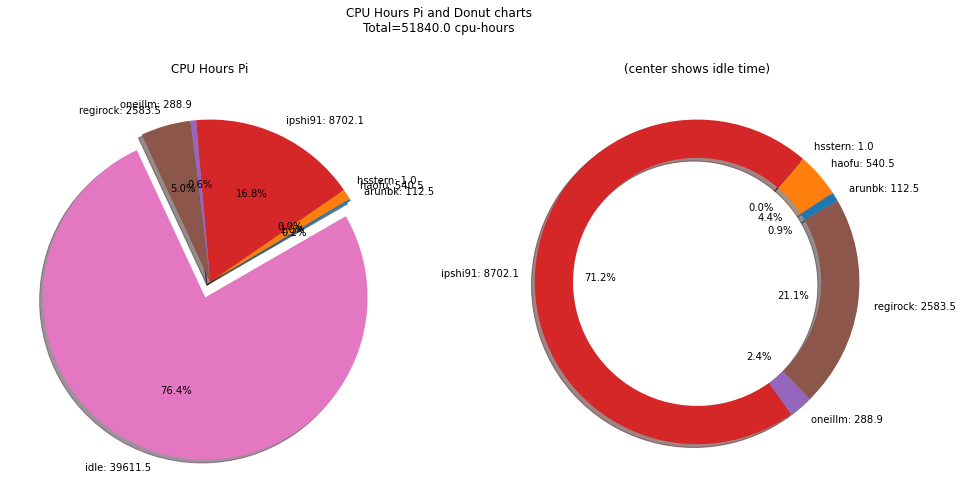

In [123]:
null_name = 'idle'
pi_users_data = hpc_lib.get_pie_slices(sum_data=SACCT_oneillm['Elapsed']*SACCT_oneillm['NCPUS'], slice_data=SACCT_oneillm['User'])
print('** ', pi_users_data)
total_time = (mpd.date2num(end_dtm) - mpd.date2num(start_date))*(12*24)
idle_time = total_time - numpy.sum(pi_users_data['value'])
pi_users_data = numpy.append(pi_users_data, numpy.array([(null_name, idle_time)], dtype=pi_users_data.dtype))
#
print('*** ')
for n,x in pi_users_data:
    print(f'{n} :: {x}')
#
explode = numpy.zeros(len(pi_users_data))
explode[-1] = .1
#
fg = plt.figure(figsize=(16,8))
ax1 = fg.add_subplot(1,2,1)
ax2 = fg.add_subplot(1,2,2)
lbls = [f'{nm.astype(str)}: {vl:.1f}' for nm,vl in pi_users_data]
#
cntr = (0., 0.)
pie_data = ax1.pie(pi_users_data['value'], labels=lbls, autopct='%1.1f%%',
                   shadow=True, explode=explode, startangle=30., wedgeprops={'width':1.})
# crcl = plt.Circle(xy=cntr, radius=.2, color='w')
# ax1.add_artist(crcl)
ix = pi_users_data['name'].astype(str) != null_name
print('** ix: ', ix)
pct_used = (total_time - idle_time)/total_time
donut = ax2.pie((pi_users_data['value'])[ix], 
                labels=[s for s,b in zip(lbls,ix) if b==True], autopct='%1.1f%%',
                   shadow=True, explode=explode[ix], startangle=30., wedgeprops={'width':pct_used} )
#
fg.suptitle(f'CPU Hours Pi and Donut charts\nTotal={total_time} cpu-hours')
ax1.set_title('CPU Hours Pi')
ax2.set_title('(center shows idle time)')

** partition: b'normal,oneillm'
** partition: b'serc'
** partition: b'oneillm'
** partition: b'dev'
** partition: b'normal'
*** my_partitions: {'serc': {}, 'oneillm': {}, 'normal': {}, 'dev': {}}
**  serc
**  oneillm
**  normal
**  dev
*** lbls:  ['19000', '19025', '19050', '19075', '19100', '19125', '19150', '19175', '19200', '19225']


<ipython-input-130-17ca107bd6d0>:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(lbls)


(-1.1018123711387884,
 1.1066428946917428,
 -1.1065362113759512,
 1.1003112585553836)

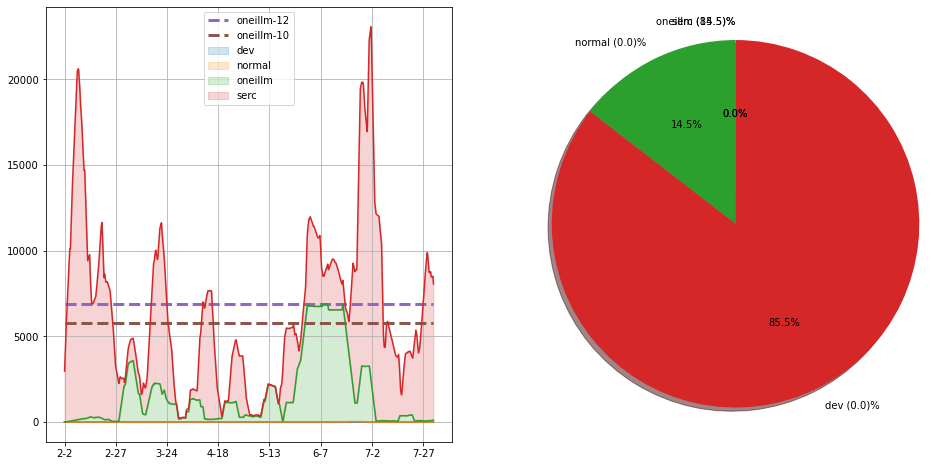

In [130]:
# CPU hours partition-layer cake
# NOTE: there are entries with multiple partition values (eg, partition=normal,serc). However, it looks like
#. this will only be for jobs that have not yet run or were canceled, so we should be able to break out partitions.
t_min=mpd.datestr2num('2021-12-01')
t_max=mpd.datestr2num('2022-05-24')
t_min=mpd.date2num(start_date)
t_max=mpd.date2num(end_date)

n_points=5000
my_partitions = []
for ptn in list(set(SACCT_obj.jobs_summary['Partition'])):
    print(f'** partition: {ptn}')
    # TODO: Can we modify the HDF5 handling code to use a str type, not bytes-array b's' type? or reverse --
    #. force bytes array when we load directly?
    if hasattr(ptn,'decode'):
        my_partitions += ptn.decode().split(',')
    else:
        my_partitions += ptn.split(',')
    
my_partitions = {ky:{} for ky in list(set(my_partitions))}
print(f'*** my_partitions: {my_partitions}')
#
elapsed_times = {}
for ptn in my_partitions.keys():
    print('** ', ptn)
    #
    if hasattr(SACCT_obj.jobs_summary['Partition'][0], 'decode'):
        ix = (SACCT_obj.jobs_summary['Partition'] == ptn.encode())
    else:
        ix = (SACCT_obj.jobs_summary['Partition'] == ptn)
    #
    #print('*** ix: ', ix[0:30])
    my_partitions[ptn]['cpuhours_weekly'] = SACCT_obj.get_cpu_hours(bin_size=7., n_points=n_points,
                                                t_min=t_min, t_max=t_max,
                                                jobs_summary=SACCT_obj.jobs_summary[ix])
    #
    elapsed_times[ptn] = numpy.sum(SACCT_obj.jobs_summary['Elapsed'][ix])
#
fg = plt.figure(figsize=(16,8))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.grid()
#

z = numpy.zeros(n_points)
for k, (ky,vl) in enumerate(sorted(my_partitions.items(), key=lambda x: x[0]) ):
    z_prev = z.copy()
    #dz = vl['cpuhours_weekly']['cpu_hours']/7.
    dz = vl['cpuhours_weekly']['cpu_hours']
    z += dz
    ln, = ax1.plot(vl['cpuhours_weekly']['time'], z, ls='-', marker='',
             zorder=11+k)
    clr = ln.get_color()
    ax1.fill_between(vl['cpuhours_weekly']['time'], z_prev, z, color=clr, alpha=.2, label=ky)
    #
    
#
ax1.plot(vl['cpuhours_weekly']['time'][0::n_points-1], numpy.ones(2)*(12*24*24.), ls='--', lw=3, label='oneillm-12')
ax1.plot(vl['cpuhours_weekly']['time'][0::n_points-1], numpy.ones(2)*(10*24*24.), ls='--', lw=3, label='oneillm-10')
fg.canvas.draw()
print('*** lbls: ', [s.get_text() for s in ax1.get_xticklabels()])
lbls = [hpc_lib.simple_date_string(mpd.num2date(max(1, float(s.get_text())) ) )[5:] for s in ax1.get_xticklabels()]
ax1.set_xticklabels(lbls)

ax1.legend(loc=0)
#
lbls,sizes = zip(*elapsed_times.items())
norm = numpy.sum(sizes)
#
lbls=list(lbls)
for k,(l,s) in enumerate(elapsed_times.items()):
    lbls[k] = f'{l} ({(100.*s/norm):.1f})%'
ax2.pie(sorted(sizes), labels=lbls,shadow=True, startangle=90, autopct='%1.1f%%')
ax2.axis('equal')
    

In [144]:
print('** dtype:\n', SACCT_obj.jobs_summary.dtype)
#
#user_cols  = ['Timelimit', 'NCPUS', 'NNodes', 'TotalCPU','NTasks']
#user_types = ['>f8', '>i8', '>i8', '>f8', '>i8', '>f8']

user_cols = ['NCPUS', 'NNodes', 'Elapsed', 'Comp_Vol']
user_types = ['>i8', '>i8', '>f8', '>f8']
#
user_aggs = numpy.zeros( shape=[len(numpy.unique(SACCT_obj.jobs_summary['User'])),],
                        dtype={'names':user_cols, 'formats':user_types })
#
ix = {usr:numpy.where(SACCT_obj.jobs_summary['User']==usr)[0] 
      for usr in numpy.unique(SACCT_obj.jobs_summary['User'])}
#

** dtype:
 [('index', '<i8'), ('User', 'S8'), ('Group', 'S7'), ('GID', 'S6'), ('JobName', 'S27'), ('JobID', 'S26'), ('JobIDRaw', 'S8'), ('Partition', 'S14'), ('State', 'S19'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', '<f8'), ('UserCPU', '<f8'), ('TotalCPU', '<f8'), ('NTasks', '<f8'), ('CPUTimeRAW', 'S9'), ('Suspended', 'S8'), ('ReqTRES', 'S40'), ('AllocTRES', 'S54'), ('MaxRSS', '<f8'), ('AveRSS', '<f8'), ('AveVMSize', '<f8'), ('MaxVMSize', '<f8'), ('MaxDiskWrite', '<f8'), ('MaxDiskRead', '<f8'), ('AveDiskWrite', '<f8'), ('AveDiskRead', '<f8'), ('JobID_parent', 'S26'), ('NGPUs', '<i8')]


In [145]:
print('*** ', user_aggs.shape, user_aggs.dtype)
print('*** ', user_cols)
user_names = numpy.unique(SACCT_obj.jobs_summary['User'])
for k,user in enumerate(user_names):
    #print('** ', [numpy.sum(SACCT_obj.jobs_summary[cl][ix[user]]) for cl in user_cols])
    #
    vals = [numpy.sum( numpy.max([numpy.zeros(len(ix[user])), SACCT_obj.jobs_summary[cl][ix[user]]], axis=0) ) 
                      for cl in user_cols[:-1]]
    vals += [numpy.sum(SACCT_obj.jobs_summary['Elapsed'][ix[user]]*24. * SACCT_obj.jobs_summary['NCPUS'][ix[user]])]
    #print('** ix: ', ix[user])
    #vals = [numpy.sum( (SACCT_obj.jobs_summary[cl][ numpy.array(ix[user])] ) )
    #        for cl in user_cols]
    #print('** vals: ', vals)
    
    #user_aggs[user_cols][k] = tuple([numpy.sum(SACCT_obj.jobs_summary[cl][ix[user]]) for cl in user_cols])
    
    user_aggs[user_cols][k] = tuple( vals )
    #user_aggs[user_cols][k] = tuple(vals)



***  (8,) [('NCPUS', '>i8'), ('NNodes', '>i8'), ('Elapsed', '>f8'), ('Comp_Vol', '>f8')]
***  ['NCPUS', 'NNodes', 'Elapsed', 'Comp_Vol']


In [146]:
# print('** user, {}'.format(user_cols ) )
# for nm,rw in zip(user_names, user_aggs):
#     print('** {}: {}, '.format(nm,rw))

<ipython-input-148-ba0d35d16ea0>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('121')
<ipython-input-148-ba0d35d16ea0>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('122')


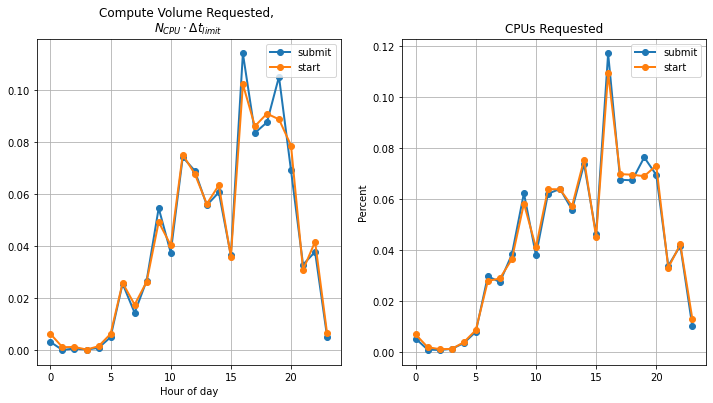

In [148]:
# time of day(-like) compute volume requests.

qs = [.5, .75, .95]
#
comp_vol_submit = SACCT_obj.get_submit_compute_vol_timeofday(qs=qs)
comp_vol_start = SACCT_obj.get_submit_compute_vol_timeofday(time_col='Start', qs=qs)
#
fg = plt.figure(figsize=(12,6))
ax1 = fg.add_subplot('121')
ax2 = fg.add_subplot('122')
ax1.grid()
ax2.grid()
#

ax1.plot(comp_vol_submit['time'], comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time']),
         ls='-', marker='o', lw=2., label='submit')
#print('*** ', numpy.sum(comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time'])))

ax1.plot(comp_vol_start['time'], comp_vol_start['cpu-time']/numpy.sum(comp_vol_start['cpu-time']),
         ls='-', marker='o', lw=2., label='start')
#print('*** ', numpy.sum(comp_vol_start['cpu-time']/numpy.sum(comp_vol_start['cpu-time'])))
#
ax2.plot(comp_vol_submit['time'], comp_vol_submit['cpus']/numpy.sum(comp_vol_submit['cpus']), ls='-', marker='o', lw=2., label='submit')
ax2.plot(comp_vol_start['time'], comp_vol_start['cpus']/numpy.sum(comp_vol_start['cpus']), ls='-', marker='o', lw=2., label='start')
#
#for k,cl in enumerate(comp_vol_tod.dtype.names[2:]):
#    ax1.plot(comp_vol_tod['time'], comp_vol_tod[cl], ls='-', marker='o', lw=2., label='$q={}$'.format(qs[k]))
#    break
#
ax1.legend(loc=0, numpoints=1)
ax1.set_title('Compute Volume Requested, \n$N_{CPU} \cdot \Delta t_{limit}$')
ax1.set_xlabel('Hour of day')
ax2.set_ylabel('Percent')

ax2.set_title('CPUs Requested')
ax2.legend(loc=1, numpoints=1)

#ax1.set_yscale('log')

***  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent', 'NGPUs')


Text(0.5, 1.0, '(Cumulative)')

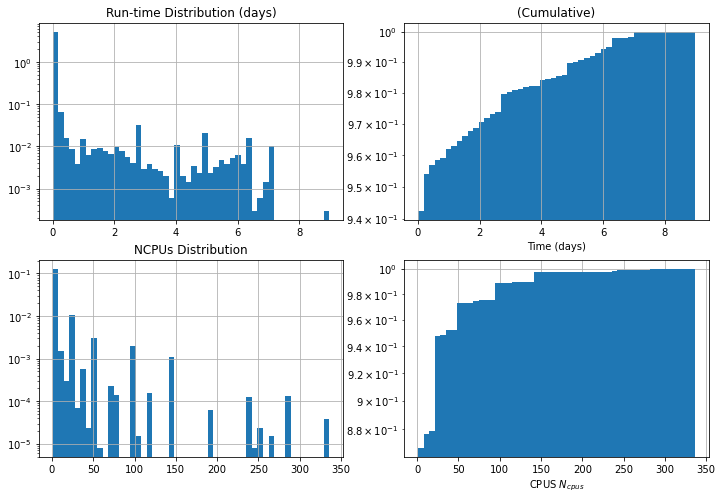

In [153]:
# compute some distributions:
print('*** ', SACCT_obj.jobs_summary.dtype.names)
run_times = SACCT_obj.get_run_times()

#
fg = plt.figure(figsize=(12,8))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
#ax1a.set_yscale('log')
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
#
hh = ax1.hist(run_times, bins=50, cumulative=False, density=True, log=True)
hh1c = ax2.hist(run_times, bins=50, cumulative=True, density=True, log=True, histtype='bar')
#hh1c = ax2.plot(sorted(run_times), numpy.array(numpy.linspace(1./len(run_times), 1.,
#                                                             len(run_times))), lw=3.0, zorder=11)
#
hh2 = ax3.hist(SACCT_obj.jobs_summary['NCPUS'], bins=50, density=True, log=True)
hh22 = ax4.hist(SACCT_obj.jobs_summary['NCPUS'], bins=50, density=True, log=True,
                 cumulative=True, histtype='bar', lw=3, zorder=11)
#hh22 = ax4.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True,
#                 cumulative=True, histtype='step', lw=3, zorder=11)
#ax1.plot(run_times, ls='', marker='.')
#print('*** ', run_times[0:20]*24, len(run_times), run_times.shape)
#
ax1.set_title('Run-time Distribution (days)')
ax3.set_title('NCPUs Distribution')
ax2.set_xlabel('Time (days)')
ax4.set_xlabel('CPUS $N_{cpus}$')
#
ax2.set_title("(Cumulative)")
#ax4.set_title("(Cumulative)")

#ax2.set_xlim(-1,800)

In [154]:
print('** ', len(run_times), len(SACCT_obj.jobs_summary['NCPUS']))

**  19104 19105


In [155]:
#ix_rt = numpy.argsort(run_times)
run_times_sorted = run_times.copy()
run_times_sorted.sort()
#
k_2 = numpy.searchsorted(run_times_sorted, 2.0)
k_7 = numpy.searchsorted(run_times_sorted, 7.0)
k_14 = numpy.searchsorted(run_times_sorted, 14.0)

#
# k_2 = numpy.searchsorted(run_times[ix_rt], 2.0)
# #k_7 = numpy.searchsorted(run_times[ix_rt], 7.0)
# k_7 = k_2 + numpy.searchsorted( (run_times[ix_rt])[k_2:], 7.0)
# k_14 = k_7 + numpy.searchsorted( (run_times[ix_rt])[k_7:], 14.0)
#
N=float(len(run_times))
print('*** quantiles for t=2,7,14 days: {}, {}, {}'.format(float(k_2)/N, k_7/N, k_14/N))
#
# percent of jobs that use N<24 cores (aka, can run on a single node). Note that these are especially
#. eligible for GCP.
N_24 = numpy.sum(SACCT_obj.jobs_summary['NCPUS']<25)
print('*** N_24/N={}'.format(N_24/N))


*** quantiles for t=2,7,14 days: 0.9691687604690117, 0.9984296482412061, 1.0
*** N_24/N=0.9477072864321608


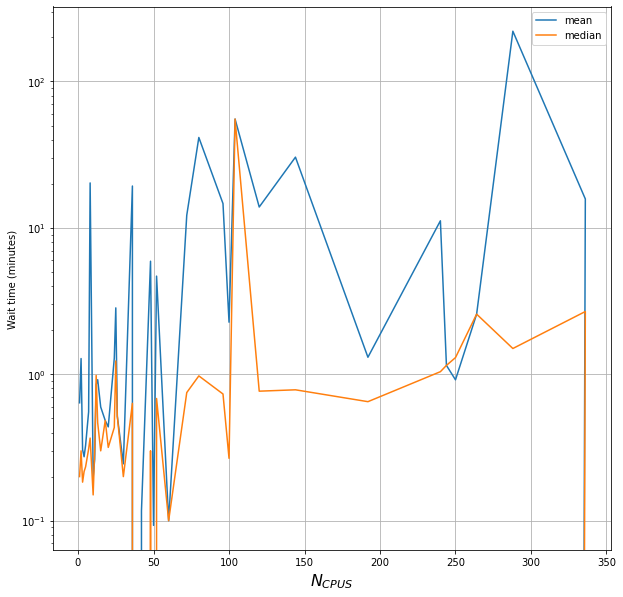

In [156]:
wait_stats = SACCT_obj.get_wait_stats(qs=[.25, .5, .75, .9])
#
fg = plt.figure(figsize=(10,10))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(wait_stats['ncpus'], wait_stats['mean']*60.*24, ls='-', label='mean')
ax1.plot(wait_stats['ncpus'], wait_stats['median']*60.*24, ls='-', label='median')
#
ax1.set_ylabel('Wait time (minutes)')
ax1.set_xlabel('$N_{CPUS}$', size=16)
#ax1.set_ylim(-.1, .5)
ax1.set_yscale('log')
ax1.legend(loc=0)

In [176]:
SACCT_serc = hpc_lib.SACCT_data_from_h5('sacct_data/sacct_pSERC_gNONE_uNone_20220107_20220706.h5', keep_raw_data=False, n_cpu=n_cpus)

**  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent', 'NGPUs')
***  oneillm
***  [b'arunbk' b'elbseitz' b'haofu' b'hsstern' b'ipshi91' b'oneillm'
 b'regirock' b'shanni30']
*** 100: 0.0 - 11.43028888888657 
*** 200: 5.715144444443285 - 25.718149999994782 
*** 300: 11.43028888888657 - 42.86358333332464 
*** 400: 8.572716666664927 - 60.009016666654496 
*** 500: 11.43028888888657 - 60.009016666654496 


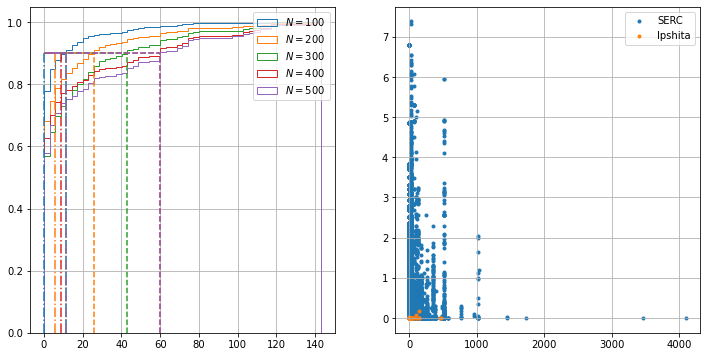

In [212]:
print('** ', SACCT_obj.jobs_summary.dtype.names)
print('*** ', SACCT_obj.group)
print('*** ', numpy.unique(SACCT_obj['User']))
#print('** ', SACCT_obj['NCPUS'])
#
ix_onm  = numpy.logical_and(SACCT_obj['User'].astype(str)=='ipshi91', 
                            SACCT_obj['Partition'].astype(str)=='oneillm')
ix_serc = numpy.logical_and(SACCT_obj['User'].astype(str)=='ipshi91', 
                            SACCT_obj['Partition'].astype(str)=='serc')
ix_ip = SACCT_serc['User'].astype(str)=='ipshi91'
#
fg = plt.figure(figsize=(12,6))
ax1 = fg.add_subplot(1,2,1)
ax2 = fg.add_subplot(1,2,2)
#
#hh = ax1.hist(SACCT_obj['NCPUS'][ix_onm], bins=25)
# ax2.scatter(SACCT_obj['NCPUS'][ix_onm], (SACCT_obj['Start'][ix_onm]-SACCT_obj['Submit'][ix_onm]),
#             marker='.', label='oneillm')
# ax2.scatter(SACCT_obj['NCPUS'][ix_serc], (SACCT_obj['Start'][ix_serc]-SACCT_obj['Submit'][ix_serc]),
#             marker='.', label='serc')

#hh = ax1.hist((SACCT_serc['Start'][ix_ip]-SACCT_serc['Submit'][ix_ip]), bins=10)
for n in (100, 200, 300, 400, 500):
    hh = ax1.hist(24.*(SACCT_serc['Start']-SACCT_serc['Submit'])[SACCT_serc['NCPUS']>=n], 
                  bins=50, histtype='step', label=f'$N={n}$', density=True, cumulative=True)
    
    clr = hh[2][0].get_edgecolor()
    
    k = numpy.searchsorted(hh[0], .9)
    x1 = hh[1][k]
    ax1.plot([x1,x1, 0], [0., .9, .9], ls='--', color=clr)
    
    k = numpy.searchsorted(hh[0], .75)
    x2 = hh[1][k]
    ax1.plot([x2,x2, 0], [0., .9, .9], ls='-.', color=clr)
    #
    print(f'*** {n}: {x2} - {x1} ')
    
ax2.scatter(SACCT_serc['NCPUS'], (SACCT_serc['Start']-SACCT_serc['Submit']),
            marker='.', label='SERC')
ax2.scatter(SACCT_serc['NCPUS'][ix_ip], (SACCT_serc['Start'][ix_ip]-SACCT_serc['Submit'][ix_ip]),
            marker='.', label='Ipshita')
ax1.grid()
ax2.grid()
#ax2.set_ylim(-.1, 1.)
ax1.legend(loc=0)
ax2.legend(loc=0)

In [218]:
print('*** ', numpy.unique(SACCT_oneillm['State']))
print('*** ', numpy.unique(SACCT_serc['State']))
print('*** ', numpy.unique(SACCT_obj['State']))
#
print(f'** oneillm: start={SACCT_oneillm.start_date}, end={SACCT_obj.end_date}')
#
def job_states(states):
    out_states={}
    #
    for s in numpy.array(states).astype(str):
        if s.startswith('CANCELLED'):
            s = 'CANCELLED'
        if not s in out_states.keys():
            out_states[s] = 0
        #
        out_states[s] += 1
    return out_states
#
states_onmp  = job_states(SACCT_oneillm['State'])
states_onmg  = job_states(SACCT_obj['State'][SACCT_obj['Partition'].astype(str)=='serc'])
#
print('\n\n Job States on ONEILLM partition and group(serc): ')
print('** onmp: ', states_onmp)
print('** onmg: ', states_onmg)


***  [b'CANCELLED by 328022' b'CANCELLED by 333190' b'CANCELLED by 333673'
 b'CANCELLED by 334253' b'CANCELLED by 394499' b'CANCELLED by 398'
 b'COMPLETED' b'FAILED' b'OUT_OF_MEMORY' b'TIMEOUT']
***  [b'CANCELLED' b'CANCELLED by 0' b'CANCELLED by 20673'
 b'CANCELLED by 215845' b'CANCELLED by 218637' b'CANCELLED by 237987'
 b'CANCELLED by 241424' b'CANCELLED by 241934' b'CANCELLED by 249676'
 b'CANCELLED by 257483' b'CANCELLED by 274689' b'CANCELLED by 274960'
 b'CANCELLED by 275116' b'CANCELLED by 282688' b'CANCELLED by 290188'
 b'CANCELLED by 292101' b'CANCELLED by 292301' b'CANCELLED by 294046'
 b'CANCELLED by 297524' b'CANCELLED by 309309' b'CANCELLED by 311419'
 b'CANCELLED by 312595' b'CANCELLED by 313134' b'CANCELLED by 313293'
 b'CANCELLED by 313386' b'CANCELLED by 313433' b'CANCELLED by 315147'
 b'CANCELLED by 330160' b'CANCELLED by 331921' b'CANCELLED by 331969'
 b'CANCELLED by 332386' b'CANCELLED by 332410' b'CANCELLED by 332956'
 b'CANCELLED by 333190' b'CANCELLED by 333204'

In [224]:
ix = numpy.logical_and((SACCT_obj['User']=='ipshi91'.encode()), SACCT_obj['NCPUS']>=100)
print('** ', numpy.sum(SACCT_obj['User']=='ipshi91'.encode()))
#flds = ['Partition', 'State', 'NCPUS', 'NNodes', 'Submit', 'Start', 'End', 'Elapsed', 'NTasks', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize' ]
flds = ['Partition', 'State', 'NCPUS', 'NNodes', 'NTasks', 'Submit', 'Start'] 
#
for rw in SACCT_obj[flds][ix]:
    print('** ', rw, None if rw['Start'] is None else rw['Start']-rw['Submit'])


**  672
**  (b'oneillm', b'FAILED', 250, 1, -9.22337204e+18, 19068.85641204, 19068.85641204) 0.0
**  (b'oneillm', b'COMPLETED', 250, 12, 12., 19068.85762731, 19068.85863426) 0.001006944446999114
**  (b'oneillm', b'CANCELLED by 334253', 240, 12, 12., 19068.86415509, 19068.86508102) 0.0009259259240934625
**  (b'oneillm', b'CANCELLED by 334253', 240, 12, 12., 19068.94640046, 19068.94721065) 0.0008101851854007691
**  (b'oneillm', b'CANCELLED by 334253', 240, 1, -9.22337204e+18, 19068.95815972, 19068.95822917) 6.944444612599909e-05
**  (b'oneillm', b'COMPLETED', 250, 12, 12., 19068.97501157, 19068.97591435) 0.0009027777778101154
**  (b'oneillm', b'COMPLETED', 240, 12, 12., 19072.57997685, 19072.58064815) 0.0006712962967867497
**  (b'oneillm', b'CANCELLED by 334253', 240, 12, 12., 19072.5840625, 19072.58498843) 0.0009259259277314413
**  (b'oneillm', b'CANCELLED by 334253', 240, 12, 12., 19072.60096065, 19072.60167824) 0.0007175925929914229
**  (b'oneillm', b'CANCELLED by 334253', 240, 12, 12

In [226]:
#print('** ', numpy.unique())
flds = ['Partition', 'State', 'NCPUS', 'NNodes', 'NTasks']
for rw in SACCT_obj[flds][SACCT_obj['User']=='ipshi91'.encode()]:
    print('** ', rw)


**  (b'oneillm', b'TIMEOUT', 7, 1, 1.)
**  (b'oneillm', b'FAILED', 7, 1, 1.)
**  (b'oneillm', b'TIMEOUT', 7, 1, 1.)
**  (b'oneillm', b'FAILED', 7, 1, 1.)
**  (b'oneillm', b'TIMEOUT', 7, 1, 1.)
**  (b'oneillm', b'FAILED', 7, 1, 1.)
**  (b'oneillm', b'FAILED', 7, 1, 1.)
**  (b'oneillm', b'FAILED', 7, 1, 1.)
**  (b'oneillm', b'FAILED', 7, 1, 1.)
**  (b'oneillm', b'FAILED', 7, 1, 1.)
**  (b'oneillm', b'FAILED', 7, 1, 1.)
**  (b'oneillm', b'FAILED', 7, 1, 1.)
**  (b'oneillm', b'FAILED', 7, 1, 1.)
**  (b'oneillm', b'FAILED', 7, 1, 1.)
**  (b'oneillm', b'FAILED', 7, 1, 1.)
**  (b'oneillm', b'TIMEOUT', 7, 1, 1.)
**  (b'oneillm', b'TIMEOUT', 7, 1, 1.)
**  (b'oneillm', b'FAILED', 7, 1, 1.)
**  (b'oneillm', b'COMPLETED', 7, 1, 1.)
**  (b'oneillm', b'FAILED', 7, 1, 1.)
**  (b'oneillm', b'COMPLETED', 7, 1, 1.)
**  (b'oneillm', b'FAILED', 7, 1, 1.)
**  (b'oneillm', b'FAILED', 7, 1, 1.)
**  (b'oneillm', b'FAILED', 7, 1, 1.)
**  (b'oneillm', b'FAILED', 7, 1, 1.)
**  (b'oneillm', b'TIMEOUT', 7, 1, 1.)


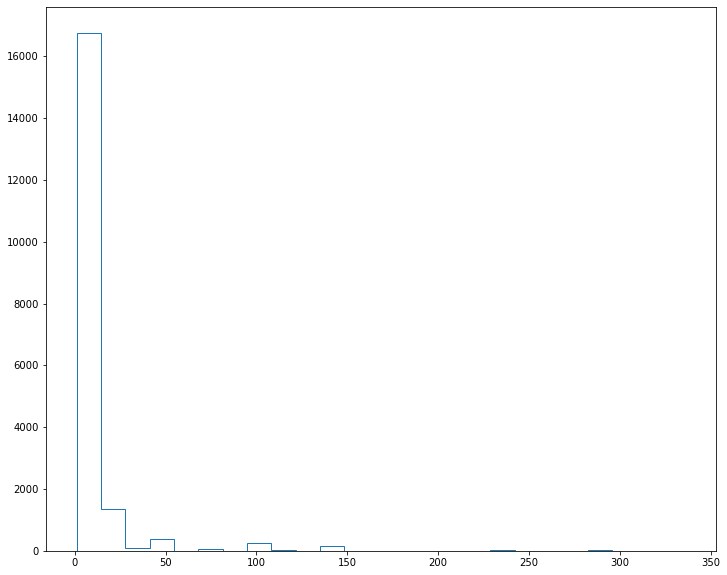

In [230]:
fg = plt.figure(figsize=(12,10))
ax1 = fg.add_subplot(1,1,1)
#
hh = ax1.hist(SACCT_obj['NCPUS'], bins=25, histtype='step')

24.0